## CORE

In [13]:
!pip install fastcore fastai2 -q

     |████████████████████████████████| 194kB 7.8MB/s 


In [0]:
from fastcore.foundation import *
from fastai2.vision.all import *
import pathlib

In [0]:
@patch
def ls(x: pathlib.Path):
    return list(x.iterdir())

## Colab_setup

In [0]:
import os

from pathlib import Path
from google.colab import drive

In [0]:
def create_path(path):
    if not os.path.isdir(path):
        path.mkdir(parents=True, exist_ok=True)
    return path

In [8]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = Path('/content/drive/My Drive')
base_path = create_path(root_dir/'Rakuten')
base_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path('/content/drive/My Drive/Rakuten')

In [0]:
colab_path = Path('/content')

In [0]:
data_path = create_path(base_path/'dataset')

In [0]:
model_path = create_path(base_path/'models')

In [0]:
# shutil.rmtree(data_path)

## download data

In [0]:
os.chdir(data_path)
# data_url = "'http://rakutendatachallenge.net/downloads/496da313-4b78-43e7-81bb-320e74670087/sigir-2020-ecomdc-release-phase1.tgz'"
# !wget {data_url} -O 'temp.tgz'

In [13]:
data_path.ls()

[Path('/content/drive/My Drive/Rakuten/dataset/temp.tgz'),
 Path('/content/drive/My Drive/Rakuten/dataset/._SIGIR-2020-EComDC-release'),
 Path('/content/drive/My Drive/Rakuten/dataset/SIGIR-2020-EComDC-release')]

In [0]:
!tar -xzf '/content/drive/My Drive/Rakuten/dataset/temp.tgz' -C '/content/'

In [16]:
(colab_path/'SIGIR-2020-EComDC-release').ls()

[Path('/content/SIGIR-2020-EComDC-release/._.DS_Store'),
 Path('/content/SIGIR-2020-EComDC-release/image'),
 Path('/content/SIGIR-2020-EComDC-release/data'),
 Path('/content/SIGIR-2020-EComDC-release/._image'),
 Path('/content/SIGIR-2020-EComDC-release/._data'),
 Path('/content/SIGIR-2020-EComDC-release/.DS_Store')]

In [0]:
# eval_url = "'http://rakutendatachallenge.net/downloads/496da313-4b78-43e7-81bb-320e74670087/eval_script.py'"
# !wget -q {eval_url}
# os.chdir(colab_path)

## EDA

As see in the competition paper

> The dataset consists of product titles,product descriptions,product images and their corresponding product type code



In [0]:
path = colab_path/'SIGIR-2020-EComDC-release'

In [22]:
(path/'data').ls()

[Path('/content/SIGIR-2020-EComDC-release/data/._.DS_Store'),
 Path('/content/SIGIR-2020-EComDC-release/data/._x_test_task1_phase1.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/._x_test_task2_phase1.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/._catalog_english_taxonomy.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/x_test_task1_phase1.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/X_train.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/._X_train.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/Y_train.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/._Y_train.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/catalog_english_taxonomy.tsv'),
 Path('/content/SIGIR-2020-EComDC-release/data/.DS_Store'),
 Path('/content/SIGIR-2020-EComDC-release/data/x_test_task2_phase1.tsv')]

In [23]:
x_train = pd.read_csv(path/'data/X_train.tsv', sep='\t'); x_train.head(2)

,Integer_id,Title,Description,Image_id,Product_id
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,1263597046,3804725264
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,1008141237,436067568
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en ma...,938777978,201115110
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,457047496,50418756
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,1077757786,278535884


In [26]:
y_train = pd.read_csv(path/'data/Y_train.tsv', sep='\t'); y_train.head()

,Integer_id,Image_id,Product_id,Prdtypecode
0,0,1263597046,3804725264,10
1,1,1008141237,436067568,2280
2,2,938777978,201115110,50
3,3,457047496,50418756,1280
4,4,1077757786,278535884,2705


In [64]:
id2cat_df = pd.read_csv(path/'data/catalog_english_taxonomy.tsv', sep='\t'); id2cat_df.sample(2)

,Prdtypecode,Top level category
21,60,Entertainment
20,50,Entertainment


In [82]:
id2cat_df['Top level category'].unique()

array(['Child', 'Household', 'Entertainment', 'Books'], dtype=object)

In [27]:
x_train.shape, y_train.shape

((84916, 5), (84916, 4))

In [34]:
x_train.isna().sum(), y_train.isna().sum()

(Integer_id         0
 Title              0
 Description    29800
 Image_id           0
 Product_id         0
 dtype: int64, Integer_id     0
 Image_id       0
 Product_id     0
 Prdtypecode    0
 dtype: int64)

Merge the `x_train` and `y_train` on their `Image_id`

In [0]:
for data in [x_train, y_train]:
    data.drop(columns='Integer_id', inplace=True)

In [44]:
df_all = x_train.merge(y_train, on=['Image_id', 'Product_id']); df_all.sample(2)

,Title,Description,Image_id,Product_id,Prdtypecode
14352,Bâche hiver ronde - Ø360 m de Astralpool - Bâche hiver piscine,Bâche hiver ronde - Ø360 m de Astralpool - Bâche hiver piscine,1138967486,2377810068,2583
1481,Batterie Gamepad Wii U,Batterie d'origine pour Gamepad - 1500mAh,1018112358,491255795,50


change the prdtype codes to the actual cat labels

In [0]:
id2lbl_dict={i: x for i, x in zip(id2cat_df.Prdtypecode.values, id2cat_df['Top level category'].values)}

In [0]:
def id2lbl(id_):
    return id2lbl_dict[id_]

In [0]:
df_all['Prdlbl'] = df_all.Prdtypecode.apply(id2lbl)

Check if the individual images and products are unique

In [54]:
df_all.Image_id.nunique(), df_all.Product_id.nunique(), len(df_all)

(84916, 84916, 84916)

check the classes that are in the training set

In [76]:
df_all.Prdlbl.unique() # we have just 27 classes

array(['Books', 'Entertainment', 'Child', 'Household'], dtype=object)

How many products are in each class?

In [83]:
{group: len(items) for group, items in df_all.groupby('Prdlbl').groups.items()}

{'Books': 20400, 'Child': 18524, 'Entertainment': 14702, 'Household': 31290}

Add the path to each image to the `df_all`

In [100]:
len((path/'image/image_training').ls())

169832

Why? Some images in the folder start with `._` after untarring. These files are corrupt so we exclude them

In [110]:
files = get_image_files(path/'image/image_training', recurse=True); len(files)

84916

In [111]:
files

(#84916) [Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1269065463_product_3953864279.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1289807039_product_4089927082.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1111482606_product_1911620052.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_846534875_product_64318908.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1015918061_product_109547943.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1322309226_product_4229922806.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1277693292_product_4023013854.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_921948032_product_170165698.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_training/image_1313200797_product_4182729555.jpg'),Path('/content/SIGIR-2020-EComDC-release/image/image_trainin

In [0]:
prdid2path_dict = dict()
for img_path in files:
    idx = re.search(pat, str(img_path)).group(0)
    # if int(idx[:-4]) == id_:
    prdid2path_dict[int(idx[:-4])] = img_path

In [0]:
def add_img_path(id_):
    return prdid2path_dict[id_]

In [0]:
df_all['image_path'] = df_all.Product_id.apply(add_img_path)

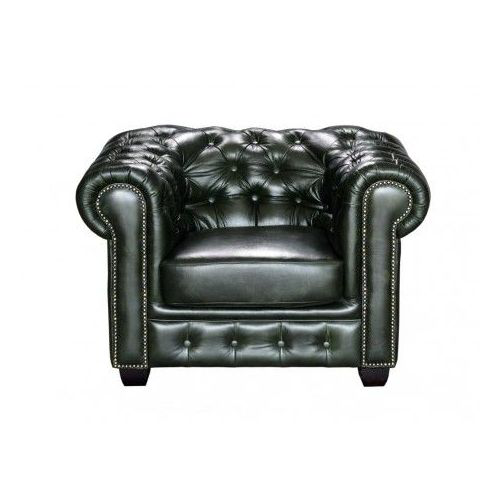

In [171]:
PILImage.create(df_all.image_path[11])

In [0]:
df_all.to_csv(data_path/'df_all.csv', index=False)

## Fin

In [174]:
df_all = pd.read_csv(data_path/'df_all.csv'); df_all.head()

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,1263597046,3804725264,10,Books,/content/SIGIR-2020-EComDC-release/image/image_training/image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,1008141237,436067568,2280,Books,/content/SIGIR-2020-EComDC-release/image/image_training/image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en ma...,938777978,201115110,50,Entertainment,/content/SIGIR-2020-EComDC-release/image/image_training/image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,457047496,50418756,1280,Child,/content/SIGIR-2020-EComDC-release/image/image_training/image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,1077757786,278535884,2705,Books,/content/SIGIR-2020-EComDC-release/image/image_training/image_1077757786_product_278535884.jpg
